In [7]:
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

file = 'datasets/mnist_data/mnist.pkl.gz'

with gzip.open(file, 'rb') as f:
    train_set, validation_set, test_set = pickle.load(f, encoding='latin1')

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

train_index = range(0, len(X_train))
validation_index = range(len(X_train), len(X_train) + len(X_validation))
test_index = range(len(X_train) + len(X_validation), len(X_train) + len(X_validation) + len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)
X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)
X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [9]:
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

In [12]:
from sklearn.cluster import KMeans

n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = pd.DataFrame(data=[], index=range(2, 21), columns=['inertia'])

for n_clusters in range(2, 21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init,
                    max_iter=max_iter, tol=tol, random_state=random_state,
                    )
    cutoff = 99
    kmeans.fit(X_train_PCA.iloc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_

In [14]:
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True, drop=False)
    countByCluster.columns = ['cluster', 'clusterCount']
    preds = pd.concat([labelsDF, clusterDF], axis=1)
    preds.columns = ['trueLabel', 'cluster']
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg(
        lambda x: x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True, drop=False)
    countMostFreq.columns = ['cluster', 'countMostFrequent']
    accuracyDF = countMostFreq.merge(countByCluster, left_on='cluster', 
                                     right_on='cluster')
    overallAccuracy = accuracyDF.countMostFrequent.sum() / accuracyDF.clusterCount.sum()
    accuracyByLabel = accuracyDF.countMostFrequent / accuracyDF.clusterCount

    return countByCluster, countByLabel, countMostFreq, accuracyDF, overallAccuracy, accuracyByLabel


In [19]:
n_clusters = 5
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2
kMeans_inertia = pd.DataFrame(data=[], index=range(2,21),
                              columns=['inertia'])
overallAccuracy_kMeansDF = pd.DataFrame(data=[], index=range(2,21),
                                        columns=['overallAccuracy'])
for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init,
                   max_iter=max_iter, tol=tol, random_state=random_state)
    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = \
           pd.DataFrame(data=X_train_kmeansClustered, index=X_train.index, \
                        columns=['cluster'])
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
           accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
           = analyzeCluster(X_train_kmeansClustered, y_train)
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

<AxesSubplot: >

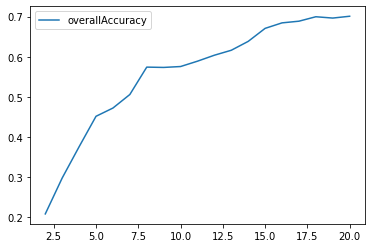

In [21]:
overallAccuracy_kMeansDF.plot()